In [1]:
import anndata as ad
import numpy as np
import pandas as pd
#import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
sys.path.insert(1, '../')
import velovae as vv
%load_ext autoreload
%autoreload 2

/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/velovae/model/model_util.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import scvelo as scv
import scanpy as sc
from skimage.draw import polygon
from shapely.geometry import Polygon
import imageio
import tifffile
from matplotlib import pyplot as plt
from PIL import Image
from scipy.stats import linregress
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.signal as signal
import peakutils
import seaborn as sns

In [3]:
adata_mean_intensities = ad.read_h5ad("path/to/adata_gcamp.h5ad")
adata_rna = ad.read_h5ad("path/to/file/adata_rna.h5ad")
adata_mean_intensities.var['Peak_Duration_log'] = np.log1p(adata_mean_intensities.var['Peak_Duration'])

In [4]:
adata_mean_intensities

AnnData object with n_obs × n_vars = 40 × 77455
    obs: 'time_point'
    var: 'cell_id', 'cell_type', 'Median', 'Median_z', 'q25', 'q25_z', 'Mean', 'Mean_z', 'SD', 'SD_log', 'SD_z', 'min', 'min_z', 'Peak_Counts', 'Peak_Counts_z', 'AUC_above_median', 'AUC_above_median_log', 'AUC_above_median_z', 'AUC_above_q25', 'AUC_above_q25_log', 'AUC_above_q25_z', 'AUC_above_min', 'AUC_above_min_log', 'AUC_above_min_z', 'Peak_Amplitude_fold', 'Peak_Amplitude_fold_log', 'Peak_Amplitude_fold_z', 'Peak_Amplitude', 'Peak_Amplitude_log', 'Peak_Amplitude_z', 'Peak_Duration', 'Peak_Duration_z', 'Peak_Duration_log'

In [5]:
custom_palette = {
    'Excitatory Neurons': '#44a843',   # green
    'Inhibitory Neurons': '#9f78c3',   # lighter purple with a blue tint
    'Neuronal Progenitors': '#9f7269', # medium brown
    'NPC': '#e36d6f',    # pure red (more red)
    'Radial Glia': '#e584c7',          # lighter pink (less red)
    'Cycling Radial Glia': '#ff9c4c',  # orange
    'Astrocytes': '#3985bb',           # medium blue
    'Transitory Neural Cells': '#909394'  # grey
}

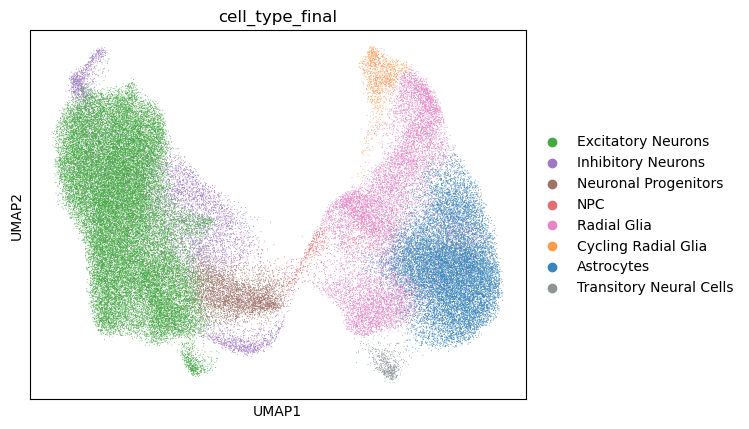

In [6]:
sc.pl.umap(adata_rna, color="cell_type_final", palette=custom_palette)

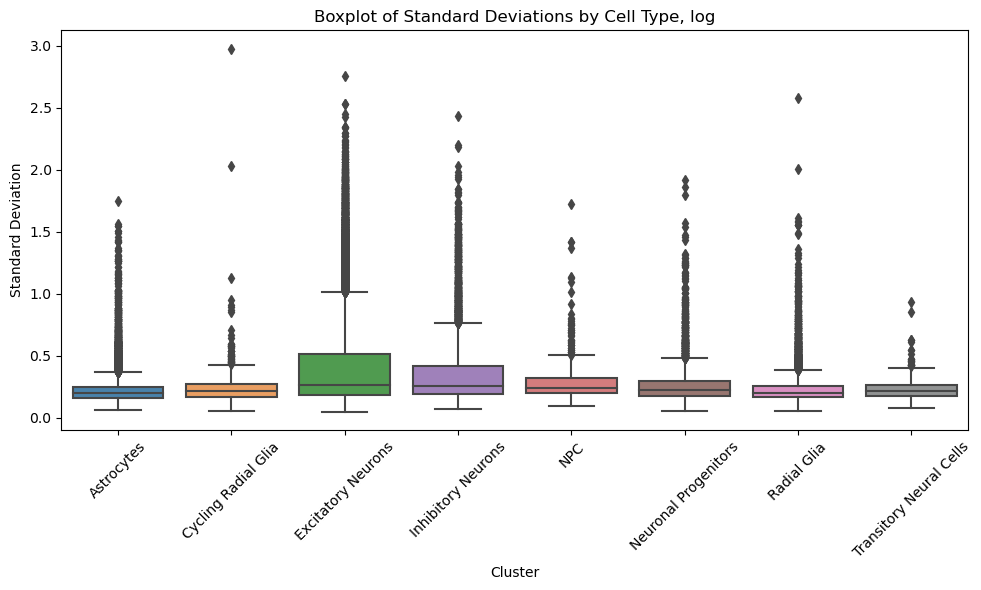

In [15]:
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "SD": adata_mean_intensities.var['SD_log']
})
sd_by_cluster_df['Cluster'] = sd_by_cluster_df['Cluster'].astype('category')
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Cluster", y="SD", palette=custom_palette)
plt.title("Boxplot of Standard Deviations by Cell Type, log")
plt.xlabel("Cluster")
plt.ylabel("Standard Deviation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

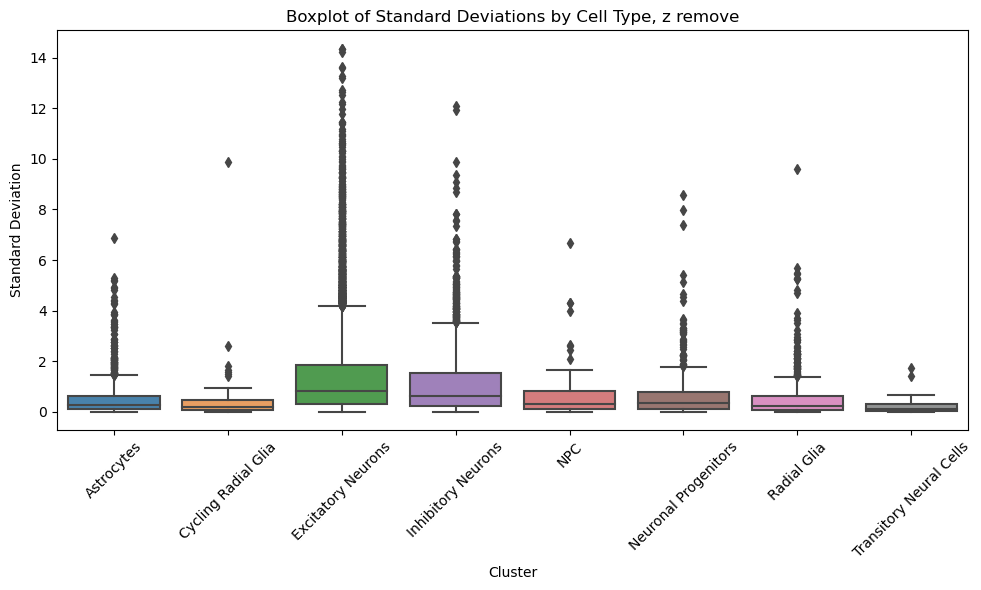

In [16]:
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "SD": adata_mean_intensities.var['SD_z']
})
sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['SD']>0]
sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['SD']<15]
sd_by_cluster_df['Cluster'] = sd_by_cluster_df['Cluster'].astype('category')
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Cluster", y="SD", palette=custom_palette)
plt.title("Boxplot of Standard Deviations by Cell Type, z remove")
plt.xlabel("Cluster")
plt.ylabel("Standard Deviation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

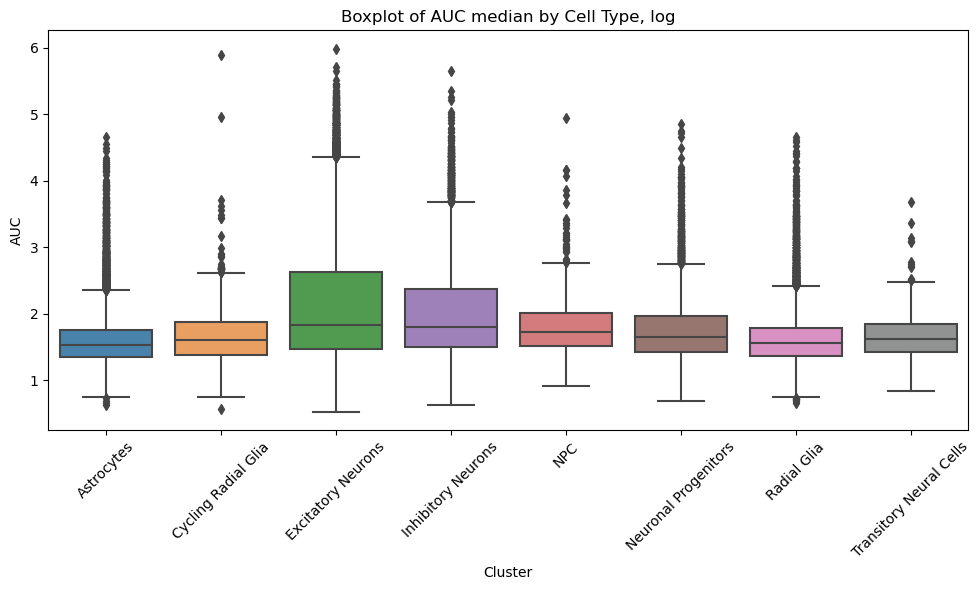

In [17]:
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "AUC": adata_mean_intensities.var['AUC_above_median_log']
})
sd_by_cluster_df['Cluster'] = sd_by_cluster_df['Cluster'].astype('category')
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Cluster", y="AUC", palette=custom_palette)
plt.title("Boxplot of AUC median by Cell Type, log")
plt.xlabel("Cluster")
plt.ylabel("AUC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

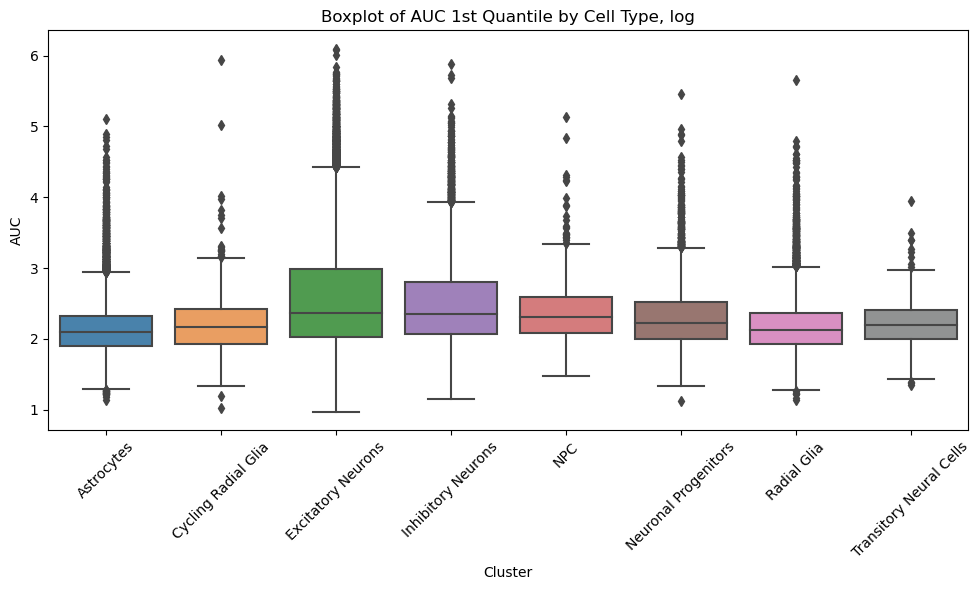

In [18]:
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "AUC": adata_mean_intensities.var['AUC_above_q25_log']
})
sd_by_cluster_df['Cluster'] = sd_by_cluster_df['Cluster'].astype('category')
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Cluster", y="AUC", palette=custom_palette)
plt.title("Boxplot of AUC 1st Quantile by Cell Type, log")
plt.xlabel("Cluster")
plt.ylabel("AUC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
adata_mean_intensities.var['cell_type'].value_counts()

cell_type
Excitatory Neurons         37077
Astrocytes                 16733
Radial Glia                11904
Inhibitory Neurons          5504
Neuronal Progenitors        3952
Cycling Radial Glia         1130
NPC                          624
Transitory Neural Cells      531
Name: count, dtype: int64

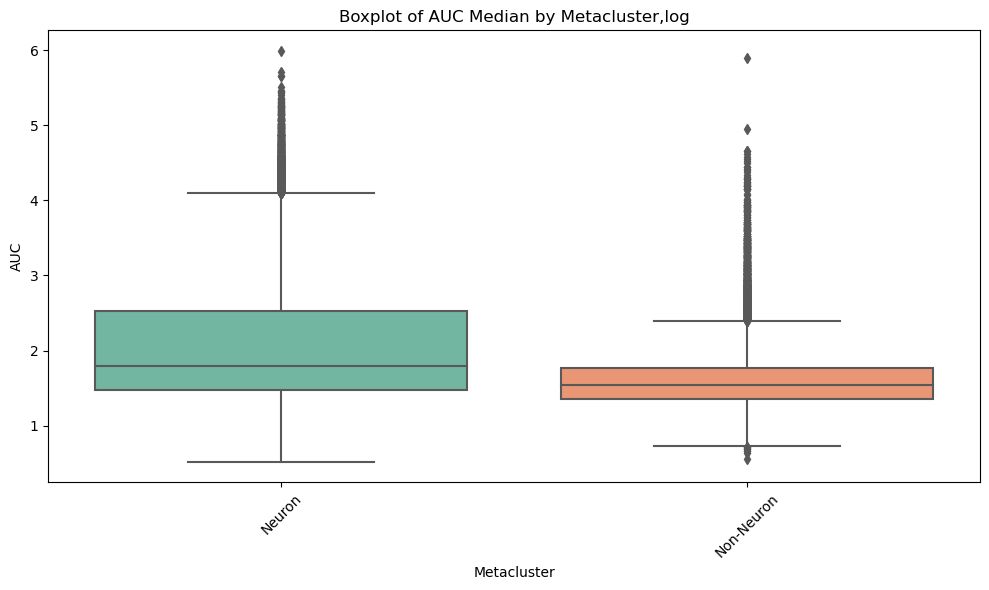

In [20]:
cluster_to_metacluster = {
    'Astrocytes': "Non-Neuron",'Cycling Radial Glia':'Non-Neuron','Excitatory Neurons':'Neuron',
    'Glial Progenitors':"Non-Neuron",'Inhibitory Neurons':'Neuron','Neuronal Progenitors':'Neuron',
    'Radial Glia':"Non-Neuron",'Transitory Neural Cells':"Non-Neuron"
}
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "AUC": adata_mean_intensities.var['AUC_above_median_log']
})
sd_by_cluster_df["Metacluster"] = sd_by_cluster_df["Cluster"].map(cluster_to_metacluster)
metacluster_order = ["Neuron", "Non-Neuron"]
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Metacluster", y="AUC", order=metacluster_order,palette="Set2")
plt.title("Boxplot of AUC Median by Metacluster,log")
plt.xlabel("Metacluster")
plt.ylabel("AUC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

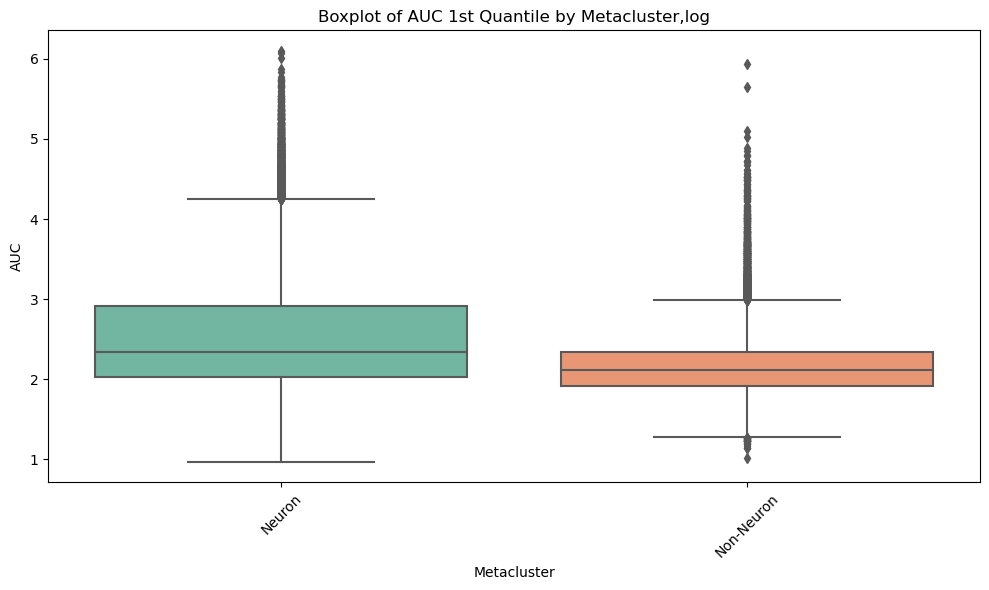

In [21]:
cluster_to_metacluster = {
    'Astrocytes': "Non-Neuron",'Cycling Radial Glia':'Non-Neuron','Excitatory Neurons':'Neuron',
    'Glial Progenitors':"Non-Neuron",'Inhibitory Neurons':'Neuron','Neuronal Progenitors':'Neuron',
    'Radial Glia':"Non-Neuron",'Transitory Neural Cells':"Non-Neuron"
}
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "AUC": adata_mean_intensities.var['AUC_above_q25_log']
})
sd_by_cluster_df["Metacluster"] = sd_by_cluster_df["Cluster"].map(cluster_to_metacluster)
metacluster_order = ["Neuron", "Non-Neuron"]
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Metacluster", y="AUC", order=metacluster_order,palette="Set2")
plt.title("Boxplot of AUC 1st Quantile by Metacluster,log")
plt.xlabel("Metacluster")
plt.ylabel("AUC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

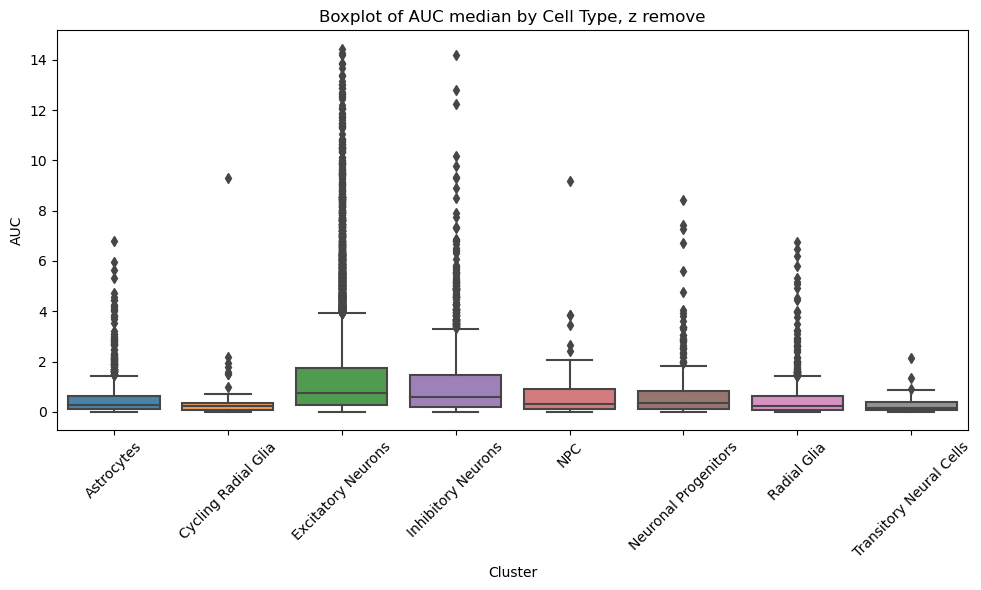

In [23]:
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "AUC": adata_mean_intensities.var['AUC_above_median_z']
})
sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['AUC']>0]
sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['AUC']<15]
sd_by_cluster_df['Cluster'] = sd_by_cluster_df['Cluster'].astype('category')
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Cluster", y="AUC", palette=custom_palette)
plt.title("Boxplot of AUC median by Cell Type, z remove")
plt.xlabel("Cluster")
plt.ylabel("AUC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

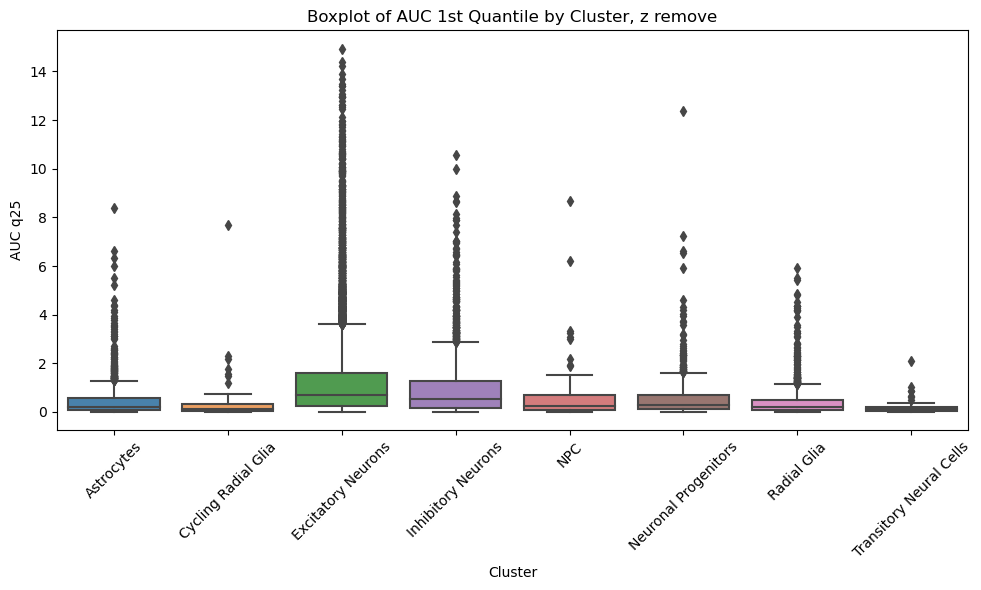

In [24]:
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "AUC_q25": adata_mean_intensities.var['AUC_above_q25_z']
})
sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['AUC_q25']>0]
sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['AUC_q25']<15]
sd_by_cluster_df['Cluster'] = sd_by_cluster_df['Cluster'].astype('category')
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Cluster", y="AUC_q25", palette=custom_palette)
plt.title("Boxplot of AUC 1st Quantile by Cluster, z remove")
plt.xlabel("Cluster")
plt.ylabel("AUC q25")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

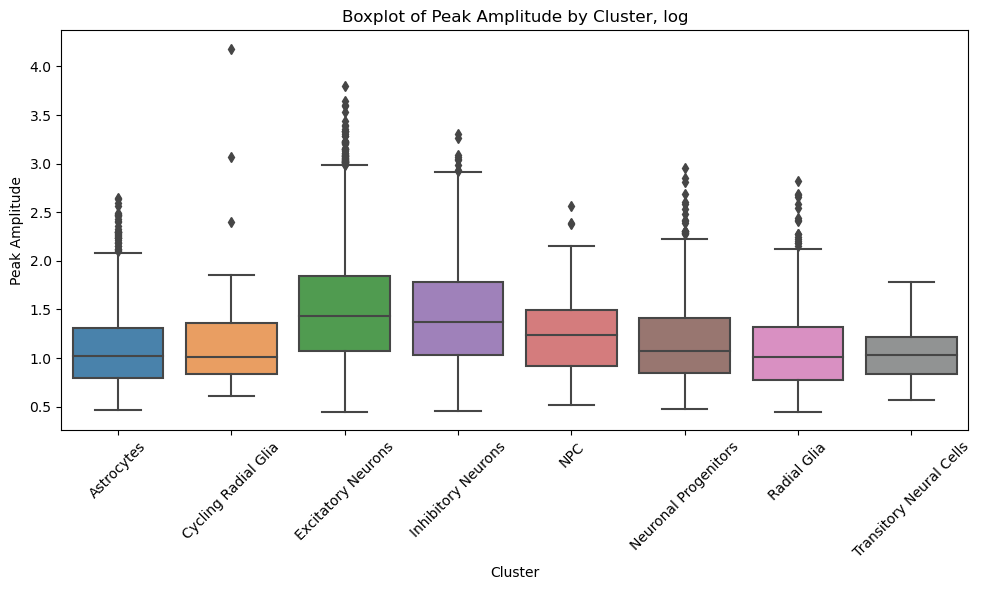

In [25]:
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "Peak_Amplitude": adata_mean_intensities.var['Peak_Amplitude'],
    "Peak_Amplitude_log": adata_mean_intensities.var['Peak_Amplitude_log'],
    "Peak_Amplitude_z": adata_mean_intensities.var['Peak_Amplitude_z'],
})
sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['Peak_Amplitude']>0]
#sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['Peak_Amplitude_z']<15]
sd_by_cluster_df['Cluster'] = sd_by_cluster_df['Cluster'].astype('category')
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Cluster", y="Peak_Amplitude_log", palette=custom_palette)
plt.title("Boxplot of Peak Amplitude by Cluster, log")
plt.xlabel("Cluster")
plt.ylabel("Peak Amplitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

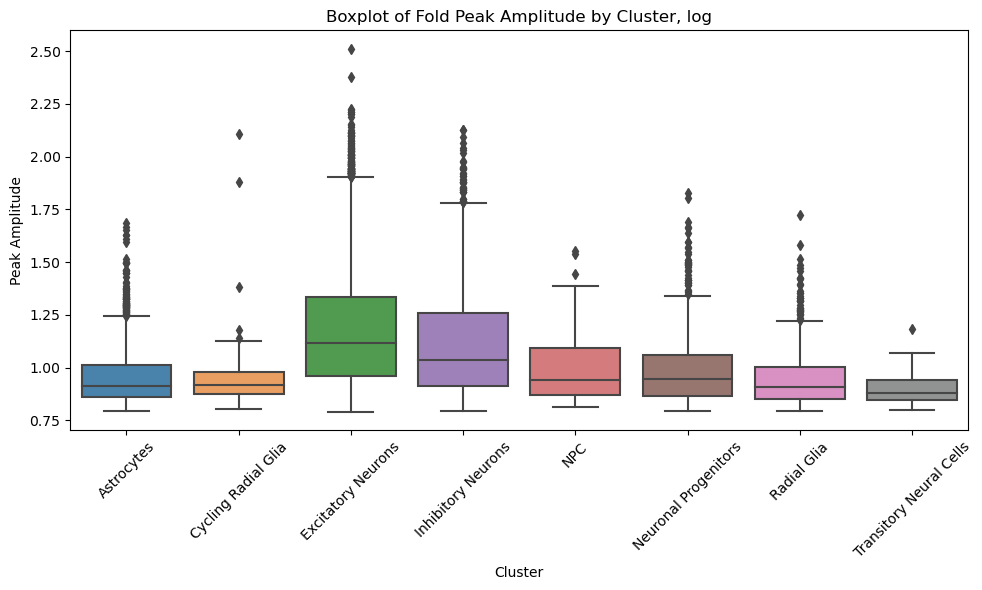

In [26]:
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "Peak_Amplitude_fold": adata_mean_intensities.var['Peak_Amplitude_fold'],
    "Peak_Amplitude_fold_log": adata_mean_intensities.var['Peak_Amplitude_fold_log'],
    "Peak_Amplitude_fold_z": adata_mean_intensities.var['Peak_Amplitude_fold_z'],
})
sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['Peak_Amplitude_fold']>0]
#sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['Peak_Amplitude_fold']<8]
sd_by_cluster_df['Cluster'] = sd_by_cluster_df['Cluster'].astype('category')
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Cluster", y="Peak_Amplitude_fold_log", palette=custom_palette)
plt.title("Boxplot of Fold Peak Amplitude by Cluster, log")
plt.xlabel("Cluster")
plt.ylabel("Peak Amplitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

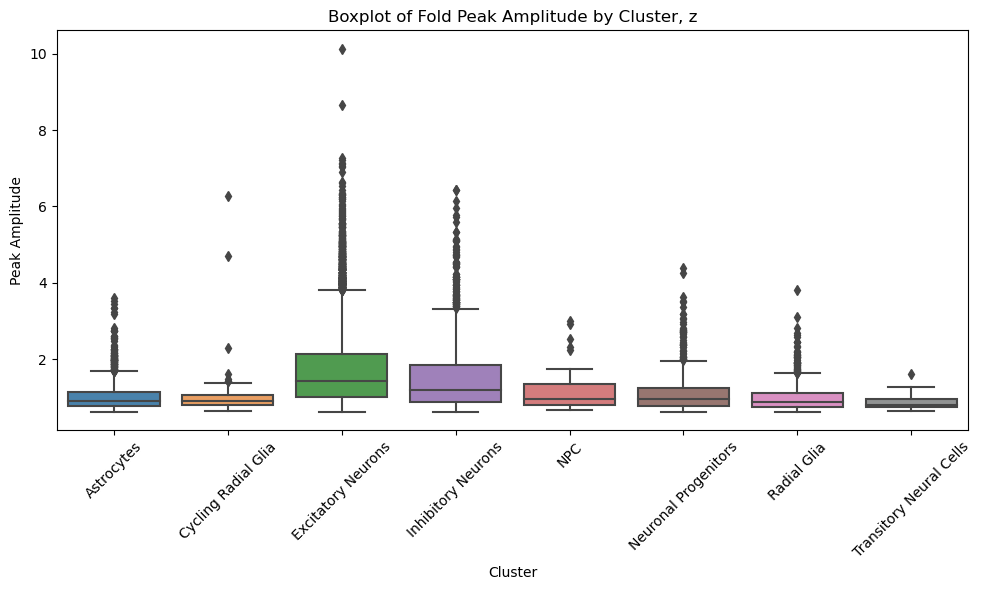

In [27]:
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "Peak_Amplitude_fold": adata_mean_intensities.var['Peak_Amplitude_fold'],
    "Peak_Amplitude_fold_log": adata_mean_intensities.var['Peak_Amplitude_fold_log'],
    "Peak_Amplitude_fold_z": adata_mean_intensities.var['Peak_Amplitude_fold_z'],
})
sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['Peak_Amplitude_fold']>0]
#sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['Peak_Amplitude_fold']<8]
sd_by_cluster_df['Cluster'] = sd_by_cluster_df['Cluster'].astype('category')
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Cluster", y="Peak_Amplitude_fold_z", palette=custom_palette)
plt.title("Boxplot of Fold Peak Amplitude by Cluster, z")
plt.xlabel("Cluster")
plt.ylabel("Peak Amplitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

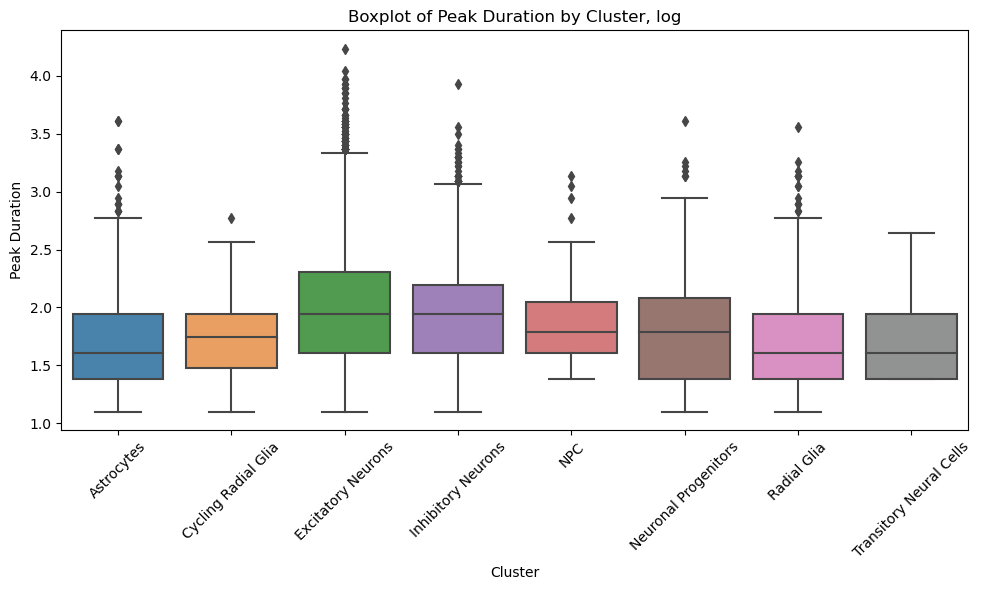

In [28]:
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "Peak_Duration": adata_mean_intensities.var['Peak_Duration'],
    "Peak_Duration_log": adata_mean_intensities.var['Peak_Duration_log'],
    "Peak_Duration_z": adata_mean_intensities.var['Peak_Duration_z'],
})
sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['Peak_Duration']>0]
#sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['Peak_Amplitude_fold']<8]
sd_by_cluster_df['Cluster'] = sd_by_cluster_df['Cluster'].astype('category')
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Cluster", y="Peak_Duration_log", palette=custom_palette)
plt.title("Boxplot of Peak Duration by Cluster, log")
plt.xlabel("Cluster")
plt.ylabel("Peak Duration")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

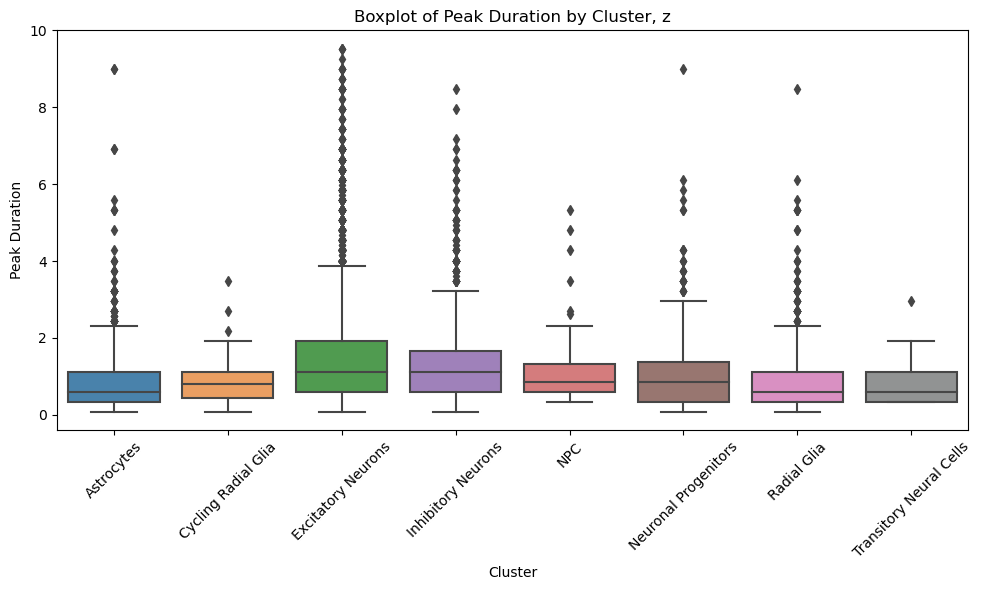

In [29]:
sd_by_cluster_df = pd.DataFrame({
    "Cluster": adata_mean_intensities.var['cell_type'],
    "Peak_Duration": adata_mean_intensities.var['Peak_Duration'],
    "Peak_Duration_log": adata_mean_intensities.var['Peak_Duration_log'],
    "Peak_Duration_z": adata_mean_intensities.var['Peak_Duration_z'],
})
sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['Peak_Duration_z']>0]
sd_by_cluster_df = sd_by_cluster_df[sd_by_cluster_df['Peak_Duration_z']<10]
sd_by_cluster_df['Cluster'] = sd_by_cluster_df['Cluster'].astype('category')
plt.figure(figsize=(10, 6))
sns.boxplot(data=sd_by_cluster_df, x="Cluster", y="Peak_Duration_z", palette=custom_palette)
plt.title("Boxplot of Peak Duration by Cluster, z")
plt.xlabel("Cluster")
plt.ylabel("Peak Duration")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
adata_rna.obs['Peak_Counts'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'Peak_Counts']
adata_rna.obs['Peak_Counts_z'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'Peak_Counts_z']
adata_rna.obs['AUC_above_median_log'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'AUC_above_median_log']
adata_rna.obs['AUC_above_q25_log'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'AUC_above_q25_log']
adata_rna.obs['Peak_Amplitude_fold_log'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'Peak_Amplitude_fold_log']
adata_rna.obs['Peak_Amplitude_log'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'Peak_Amplitude_log']
adata_rna.obs['Peak_Duration_log'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'Peak_Duration_log']
adata_rna.obs['AUC_above_median'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'AUC_above_median']
adata_rna.obs['AUC_above_q25'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'AUC_above_q25']
adata_rna.obs['Peak_Amplitude_fold'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'Peak_Amplitude_fold']
adata_rna.obs['Peak_Amplitude'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'Peak_Amplitude']
adata_rna.obs['Peak_Duration'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'Peak_Duration']
adata_rna.obs['SD'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'SD']
adata_rna.obs['SD_log'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'SD_log']
adata_rna.obs['SD_z'] = adata_mean_intensities.var.loc[adata_rna.obs_names,'SD_z']



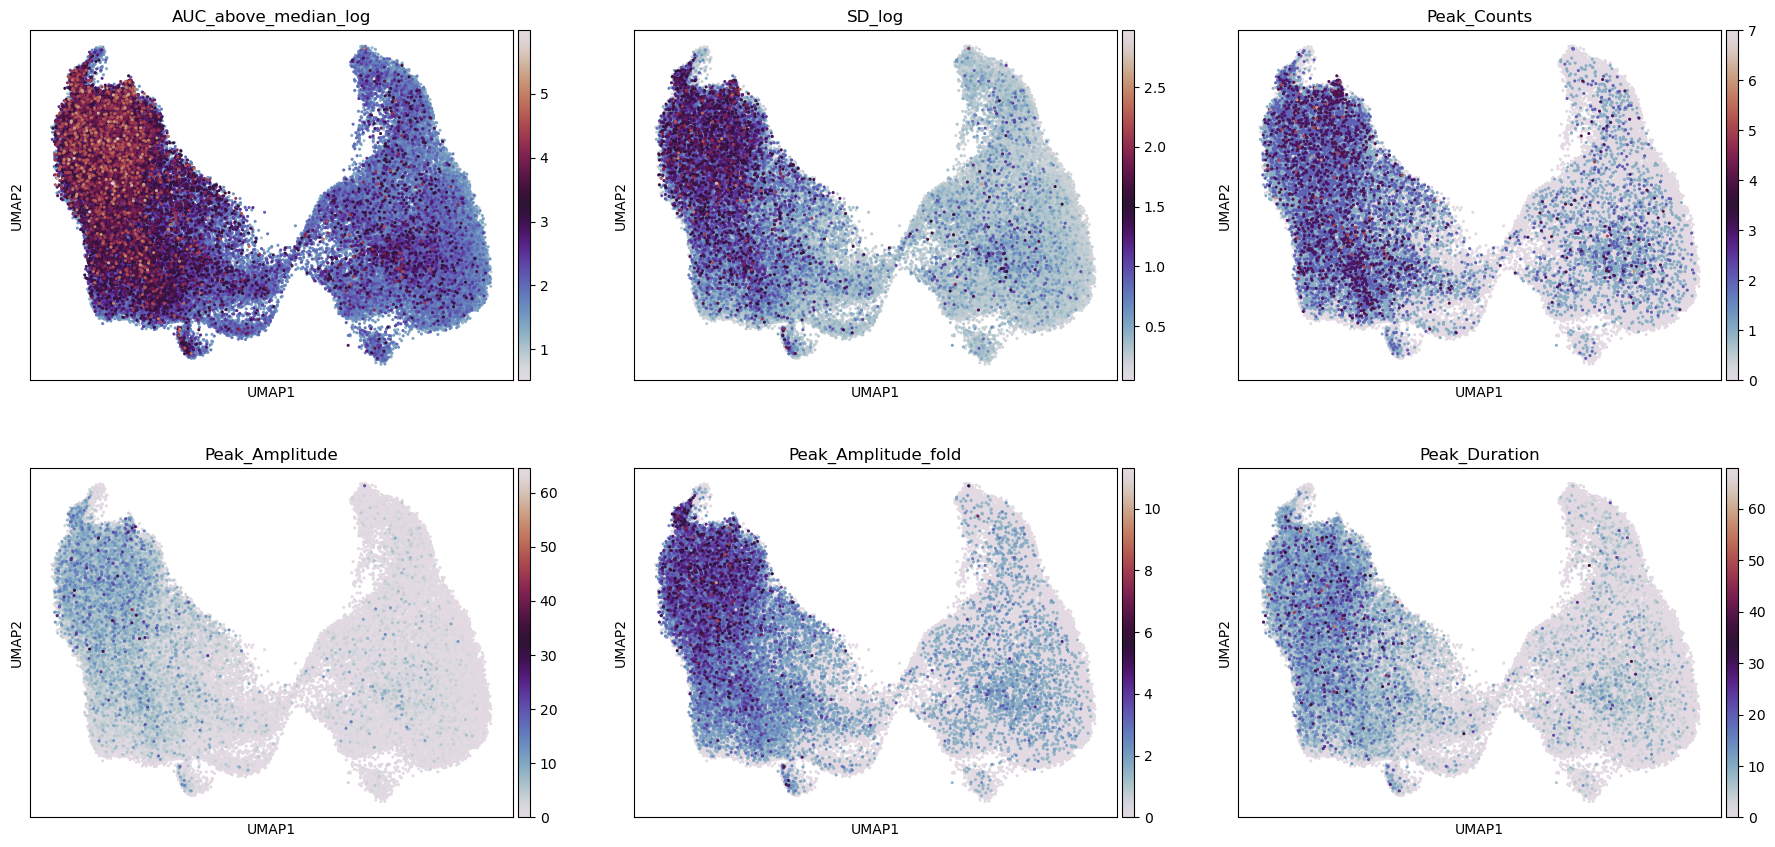

In [23]:
sc.pl.umap(adata_rna, color=["AUC_above_median_log",'SD_log','Peak_Counts',
                             'Peak_Amplitude','Peak_Amplitude_fold','Peak_Duration'], 
           color_map='twilight', size=20, ncols=3)

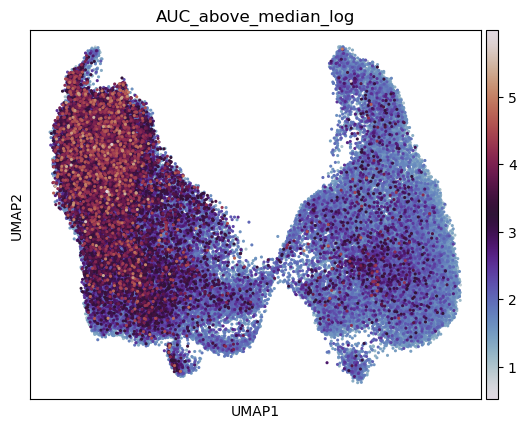

In [35]:
sc.pl.umap(adata_rna, color="AUC_above_median_log", color_map='twilight', size=20)

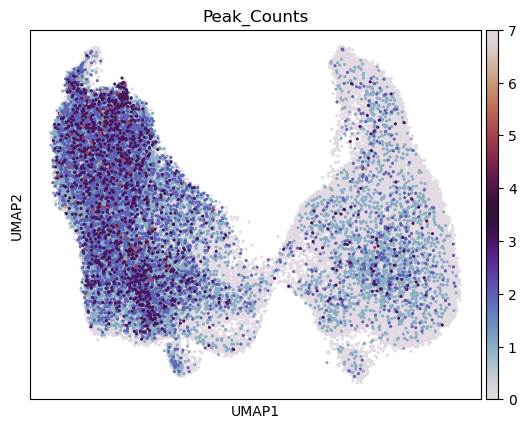

In [36]:
sc.pl.umap(adata_rna, color="Peak_Counts", color_map='twilight', size=20)

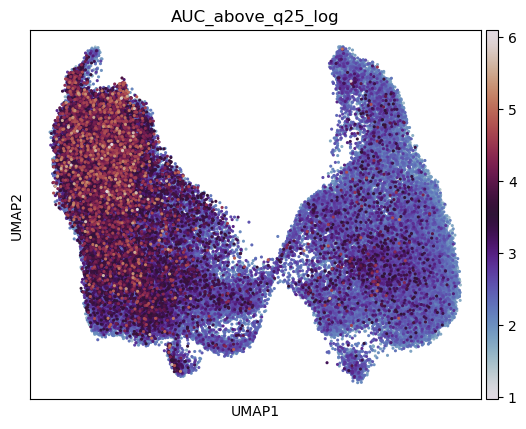

In [37]:
sc.pl.umap(adata_rna, color="AUC_above_q25_log", color_map='twilight', size=20)

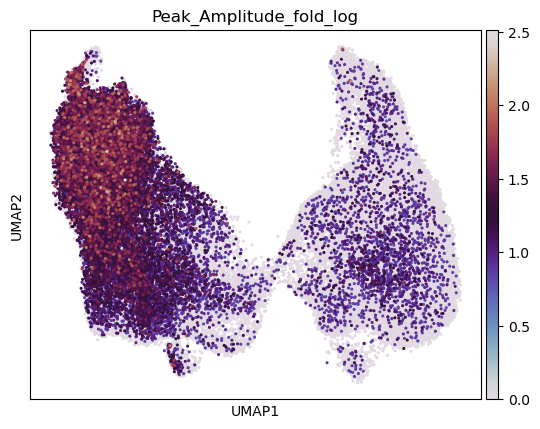

In [38]:
sc.pl.umap(adata_rna, color="Peak_Amplitude_fold_log", color_map='twilight', size=20)

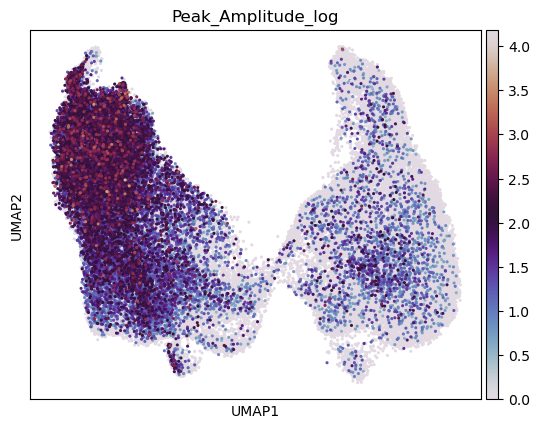

In [39]:
sc.pl.umap(adata_rna, color="Peak_Amplitude_log", color_map='twilight', size=20)

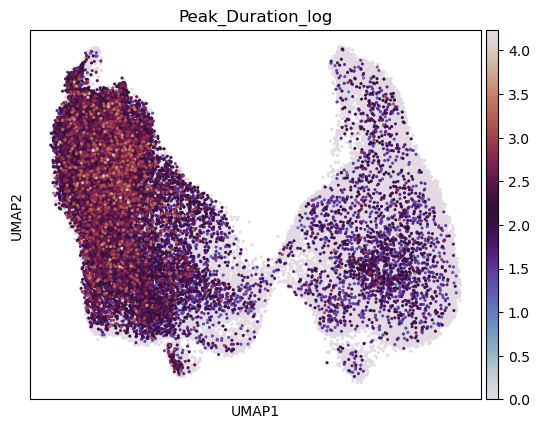

In [40]:
sc.pl.umap(adata_rna, color="Peak_Duration_log", color_map='twilight', size=20)

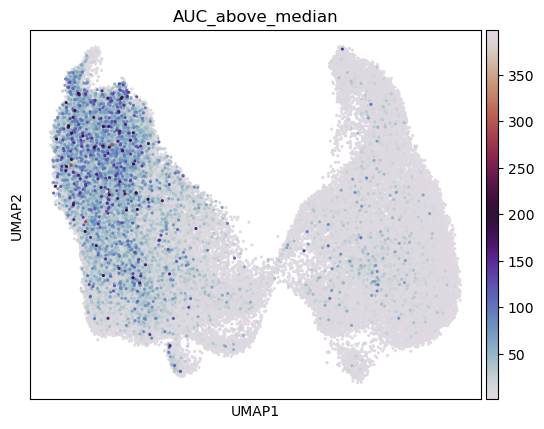

In [42]:
sc.pl.umap(adata_rna, color="AUC_above_median", color_map='twilight', size=20)

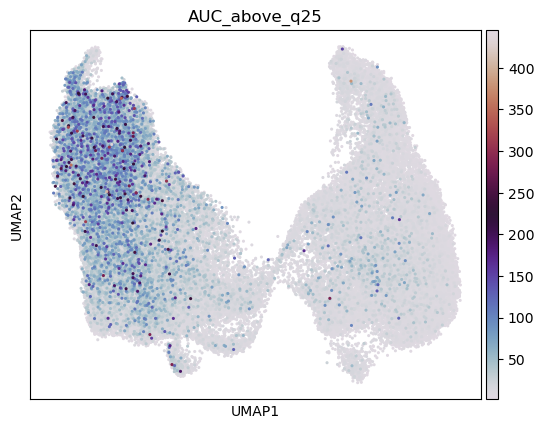

In [43]:
sc.pl.umap(adata_rna, color="AUC_above_q25", color_map='twilight', size=20)

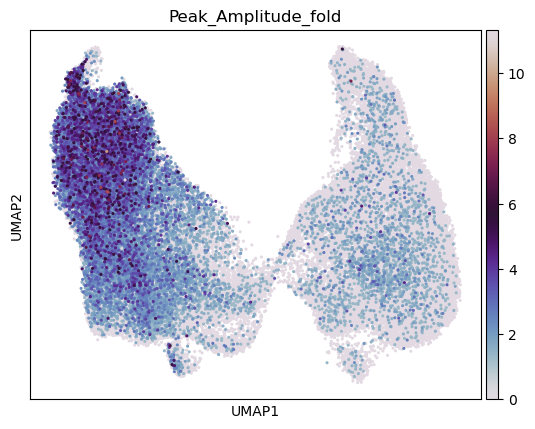

In [44]:
sc.pl.umap(adata_rna, color="Peak_Amplitude_fold", color_map='twilight', size=20)

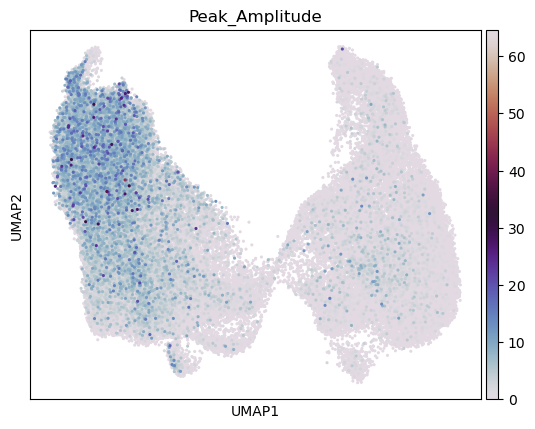

In [45]:
sc.pl.umap(adata_rna, color="Peak_Amplitude", color_map='twilight', size=20)